In [73]:
%matplotlib inline
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from statistics import mean
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence


In [106]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted


class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.attention = SelfAttention(inp)  # Attention layer with input dimension
        self.rnnLayer = nn.RNN(inp, hidden_dim, batch_first=True)
        self.outputLayer = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim
        self.resetHidden()
        self.inp = inp

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Applying attention first
        attn_out = self.attention(x)
        # Feeding the output of the attention layer into the RNN
        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Applying the final output layer
        out = torch.sigmoid(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Feeding the output of the attention layer into the RNN
                out, h0 = self.rnnLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


model = NetRNNWithAttention()

In [75]:
class NetRNN(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNN, self).__init__()
        self.rnnLayer = nn.RNN(inp, hidden_dim, batch_first=True)
        self.outputLayer = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim
        self.resetHidden()
        self.inp = inp

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        out = torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                out, h0 = self.rnnLayer(x[l][i].reshape((1, 1, self.inp)), h0)
                H.append(out.detach().numpy().flatten())
                # print(out.detach().numpy().flatten().shape)
            out = torch.tanh(out)
            out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
                # print(out.detach().numpy().flatten().shape)
        return numpy.array(O), numpy.array(H)


model = NetRNN()

In [42]:
def generateTrainData(num_samples, min_length, max_length):
    s = []  # Sequences (list of arrays)
    t = []  # Targets (list of labels)

    for _ in range(num_samples):
        # Randomized common length between min_length and max_length
        common_length = np.random.randint(min_length, max_length + 1)

        # Given arrays
        array_A = np.full(common_length, 0.5)
        array_B = np.full(common_length, 0.5)
        array_C = np.full(common_length, 0.5)

        # Random index for array A
        index_A = np.random.randint(common_length)
        value_A = np.random.choice([0, 1])
        array_A[index_A] = value_A

        # Different random index for array B
        indices_B = np.delete(
            np.arange(common_length), index_A
        )  # Removing the index used in Array A
        index_B = np.random.choice(indices_B)
        value_B = np.random.choice([0, 1])
        array_B[index_B] = value_B

        # Setting the last index of array C to either 0 or 1
        value_C = np.random.choice([0, 1])
        array_C[-1] = value_C

        # Generating label based on value_C
        label = int((value_A != value_B) if value_C == 0 else (value_A == value_B))
        label_arr = [label]
        # Combine arrays
        combined_array = np.vstack([array_A, array_B, array_C]).T

        s.append(combined_array)
        t.append(label_arr)

    return s, numpy.array(t)  # Returning as lists

In [27]:
num_seq = 2
array_min_length = 5
array_max_length = 10
sequences, labels = generateTrainData(num_seq, array_min_length, array_max_length)
sequences, labels

([array([[0.5, 0.5, 0.5],
         [0.5, 0. , 0.5],
         [0.5, 0.5, 0.5],
         [0. , 0.5, 0.5],
         [0.5, 0.5, 1. ]]),
  array([[0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [1. , 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0. , 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 1. ]])],
 array([[1],
        [0]]))

In [35]:
model = NetRNNWithAttention()
sequences, labels = generateTrainData(100, 10, 10)
output = model(torch.Tensor(sequences))
print(output.shape)
print(model)

torch.Size([100])
NetRNNWithAttention(
  (attention): SelfAttention(
    (query): Linear(in_features=3, out_features=3, bias=True)
    (key): Linear(in_features=3, out_features=3, bias=True)
    (value): Linear(in_features=3, out_features=3, bias=True)
    (softmax): Softmax(dim=2)
  )
  (rnnLayer): RNN(3, 12, batch_first=True)
  (outputLayer): Linear(in_features=12, out_features=1, bias=True)
)


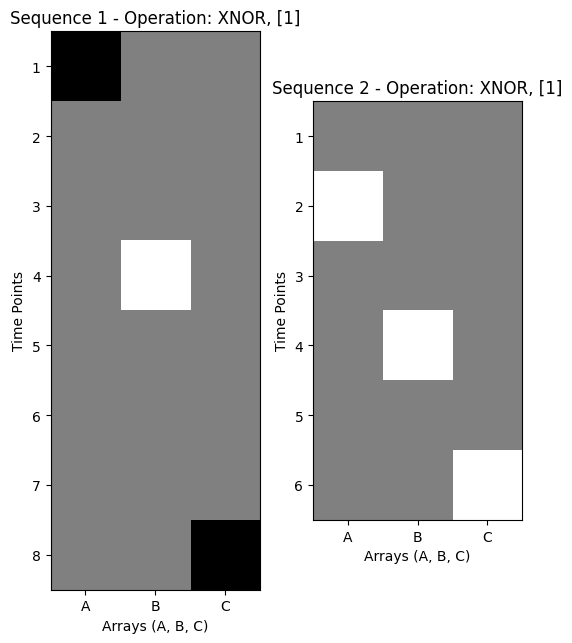

In [18]:
# Assuming sequences and labels are already generated using generateTrainData
num_samples = len(sequences)  # Number of samples to display

# Plotting
# Adjust the figure size to accommodate horizontal layout
plt.figure(figsize=(3 * num_samples, 15))

for i, (seq, label) in enumerate(zip(sequences, labels)):
    # Reshape each sequence for visualization
    reshaped_sequence = seq  # Use the sequence as it is

    # Add a subplot for each sequence in a horizontal layout
    ax = plt.subplot(1, num_samples, i + 1)
    img = ax.imshow(reshaped_sequence, cmap="gray", vmin=0.0, vmax=1.0)

    # Determine the operation title based on the label
    operation_title = "XOR" if label == 0 else "XNOR"

    # Setting the title with the operation label
    ax.set_title(f"Sequence {i+1} - Operation: {operation_title}, {label}")

    # Setting labels for features (X-axis) and detailed time points (Y-axis)
    ax.set_xlabel("Arrays (A, B, C)")
    ax.set_ylabel("Time Points")

    # Setting tick marks for each array on the X-axis
    ax.set_xticks(range(3))
    ax.set_xticklabels(["A", "B", "C"])

    # Setting tick marks for each time point on the Y-axis
    # Here, the number of ticks should be equal to the length of the sequence (number of rows)
    ax.set_yticks(range(reshaped_sequence.shape[0]))
    ax.set_yticklabels([f"{j+1}" for j in range(reshaped_sequence.shape[0])])

# Adding a colorbar as the key, placed at the side
# cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust these values as needed for positioning
# cbar = plt.colorbar(img, cax=cbar_ax)
# cbar.set_ticks([0, 1])
# cbar.set_ticklabels(['0 (Black)', '1 (White)'])

# Adjust the main figure to make room for the colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

In [212]:
def evaluate_model(model, test_data, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for seq, target in test_data:
            seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0)
            target_tensor = torch.tensor(target, dtype=torch.float32)

            output = model(seq_tensor)
            loss = criterion(output, target_tensor)
            test_loss += loss.item()

            predictions = (output >= 0.5).float()
            total_correct += (predictions == target_tensor).sum().item()
            total_samples += target_tensor.numel()

    avg_loss = test_loss / len(test_data)
    avg_accuracy = total_correct / total_samples
    return avg_loss, avg_accuracy

In [227]:
collectorA = dict()
array_min_length = 17  # Define the min length of Arrays A, B, C
array_max_length = 25  # Define the max length of Arrays A, B, C
num_samples = 100
for rep in range(1):
    for kind in ["NetRNNWithAttention" ,"RNN"]:
        if kind == "RNN":
            model = NetRNN(hidden_dim=12, inp=3)
        if kind == "NetRNNWithAttention":
            model = NetRNNWithAttention(hidden_dim=12, inp=3)
        optimizer = optim.Adam(model.parameters())
        error = nn.MSELoss()
        acc = 0.0
        W = []
        A = []

        while acc < 0.97:
            model.resetHidden()
            sequences, targets = generateTrainData(
                num_samples, array_min_length, array_max_length
            )
            sequences = numpy.array(sequences)  # Convert to numpy array

            divs = []
            for seq, target in zip(sequences, targets):
                optimizer.zero_grad()
                # Process each sequence individually
                seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(
                    0
                )  # Add batch dimension
                target_tensor = torch.tensor(
                    target, dtype=torch.float32
                )  # Add batch dimension
                # seq_tensor =torch.Tensor(seq.reshape(1, seq.shape[0], 3))
                output = model(seq_tensor)
                loss = error(output, target_tensor)
                loss.backward()
                optimizer.step()

                div = output.detach().numpy() - target_tensor.numpy()
                divs.append(1.0 - abs(div).mean())

            W.append(loss.item())
            acc = mean(divs)
            A.append(acc)
            print(f"acc: {acc}")

            # Restart training if not converging
            if acc < 0.97 and len(A) > 2000:
                if kind == "RNN":
                    model = NetRNN(hidden_dim=12, inp=3)
                if kind == "NetRNNWithAttention":
                    model = NetRNNWithAttention(hidden_dim=12, inp=3)
                optimizer = optim.Adam(model.parameters())
                acc = 0.0
                W = []
                A = []
                print("repeat")

        # torch.save(model, f"model{rep}.pth")
        collectorA["{0} {1}".format(kind, rep)] = A
        torch.save(model, "models/model_{0}_{1}.model".format(kind, rep))
        print("{0} {1}".format(kind, rep), len(A))
        print(f"RNN {rep}", len(A))

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_69101/4171570184.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequences = numpy.array(sequences)  # Convert to numpy array


acc: 0.5084411138296128
acc: 0.4955152106285095
acc: 0.4986448657512665
acc: 0.5020590135455132
acc: 0.49611291736364366
acc: 0.499186604321003
acc: 0.5028960201144218
acc: 0.5002873572707176
acc: 0.4981431496143341
acc: 0.4988619673252106
acc: 0.49853614866733553
acc: 0.5035735249519349
acc: 0.5042756316065788
acc: 0.5019648438692093
acc: 0.5027036035060882
acc: 0.4976484704017639


KeyboardInterrupt: 

In [ ]:
array_min_length = 5
array_max_length = 10
analysis_interval = 500  # Interval for performing analysis

# Training Loop
for rep in range(1):
    model = NetRNNWithAttention(hidden_dim=12)
    optimizer = optim.Adam(model.parameters())
    error = nn.MSELoss()
    acc = 0.0
    W = []  # To store loss values
    A = []  # To store accuracy values

    iteration = 0
    while acc < 0.97:
        model.resetHidden()
        sequences, targets = generateTrainData(2, array_min_length, array_max_length)

        divs = []
        for seq, target in zip(sequences, targets):
            optimizer.zero_grad()
            seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0)
            target_tensor = torch.tensor([target], dtype=torch.float32)

            output = model(seq_tensor)
            loss = error(output, target_tensor)
            loss.backward()
            optimizer.step()

            div = output.detach().numpy() - target_tensor.numpy()
            divs.append(1.0 - abs(div).mean())

        W.append(loss.item())
        acc = mean(divs)
        A.append(acc)
        # print(f"acc: {acc}")

        # Analysis Part
        if iteration % analysis_interval == 0:
            analysis_sequences, _ = generateTrainData(
                1, array_min_length, array_max_length
            )
            analysis_seq_tensor = torch.tensor(
                analysis_sequences[0], dtype=torch.float32
            ).unsqueeze(0)
            analysis_outputs, analysis_hidden_states = model.step(analysis_seq_tensor)

            # Logging
            # mean_outputs = analysis_outputs.mean(axis=0)
            # std_outputs = analysis_outputs.std(axis=0)
            # print(f"Analysis - Step Function Outputs: Mean = {mean_outputs}, Std Dev = {std_outputs}")

            # mean_hidden_states = analysis_hidden_states.mean(axis=0)
            # std_hidden_states = analysis_hidden_states.std(axis=0)
            # print(f"Analysis - Step Function Hidden States: Mean = {mean_hidden_states}, Std Dev = {std_hidden_states}")

            # Visualization
            # plt.figure(figsize=(12, 4))
            # plt.subplot(1, 2, 1)
            # plt.plot(analysis_outputs)
            # plt.title("Step Function Outputs Over Time")
            # plt.xlabel("Timestep")
            # plt.ylabel("Output")

            # plt.subplot(1, 2, 2)
            # plt.plot(analysis_hidden_states)
            # plt.title("Hidden States Over Time")
            # plt.xlabel("Timestep")
            # plt.ylabel("Hidden State Value")

            # plt.tight_layout()
            # plt.show()

        # Restart training if not converging
        if acc < 0.97 and len(A) > 2000:
            model = NetRNNWithAttention(hidden_dim=12)
            optimizer = optim.Adam(model.parameters())
            acc = 0.0
            W = []
            A = []
            print("repeat")

        iteration += 1

    print(f"RNN {rep}", len(A))

In [57]:
def symbolEntropy(D, base=2):
    value, counts = numpy.unique(D, return_counts=True)
    return entropy(counts, base=base)


def computeTransmissionHfast(I, H, O, maskC, maskNC, iMult=2, oMult=2):
    # print("I H O",I.shape,H.shape,O.shape)
    B = numpy.bitwise_and(H, maskNC)
    IB = (B * iMult) + I
    AB = H  # numpy.bitwise_and(H,maskC+maskNC)
    BO = (B * oMult) + O
    IAB = (AB * iMult) + I
    IBO = (B * (iMult * oMult)) + (I * oMult) + O
    ABO = (AB * oMult) + O
    IABO = (AB * (iMult * oMult)) + (I * oMult) + O
    hB = symbolEntropy(B, base=2)
    hIB = symbolEntropy(IB, base=2)
    hAB = symbolEntropy(AB, base=2)
    hBO = symbolEntropy(BO, base=2)
    hIAB = symbolEntropy(IAB, base=2)
    hIBO = symbolEntropy(IBO, base=2)
    hABO = symbolEntropy(ABO, base=2)
    hIABO = symbolEntropy(IABO, base=2)
    # -H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    # print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return -hB + hIB + hAB + hBO - hIAB - hIBO - hABO + hIABO


def singleShrinkingDecompositionInformation(I, H, O, width, iMult=2, oMult=2):
    nodes = list(range(width))
    cols = []
    colh = []
    while len(nodes) > 0:
        infos = []
        for node in nodes:
            subset = copy.deepcopy(nodes)
            subset.remove(node)
            maskA = 0
            for s in subset:
                maskA += 1 * (2**s)
            maskA = int(maskA)
            maskB = numpy.bitwise_and(numpy.bitwise_not(maskA), ((2**width) - 1))
            h = computeTransmissionHfast(
                I, H, O, maskA, maskB, iMult=iMult, oMult=oMult
            )
            infos.append(h)
        nodeToDrop = nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols, colh


def getOutTaH(model, dataSet):
    O, H = model.step(torch.Tensor(dataSet))
    # print(H.shape,H.min(),H.max())
    # figure()
    # hist(H.flatten())
    H = H.transpose()
    O = O.transpose()
    B = numpy.zeros(H.shape)
    clusterNr = 2
    for i in range(B.shape[0]):
        a = H[i].reshape(-1, 1)
        if len(numpy.unique(a)) == 1:
            who = numpy.random.randint(len(a))
            a[who] = 1 - a[who]
        kmeans = KMeans(n_clusters=clusterNr).fit(a)
        B[i] = kmeans.labels_
        # B[i]=1.0*(H[i]>numpy.median(H[i]))

    H = numpy.zeros((H.shape))
    for i in range(12):
        H += B[i] * (clusterNr**i)
    H = H.astype((int))
    return O, H


def shrinkingDecompositionInformation(
    model, width, dataSet, target, numbers=[0, 1, 2], whichTS=5, dsLength=8
):
    output, H = getOutTaH(model, dataSet)
    output = output.transpose()[whichTS::dsLength].transpose()
    # print("target.shape",target.shape,"output.shape",output.shape,"H.shape",H.shape,"dataset.shape",dataSet.shape)
    H = H.transpose()[whichTS::dsLength].transpose()
    # target=target.transpose()[whichTS::dsLength].transpose()
    # print(H.shape,target.shape,numpy.array(range(512))[whichTS::dsLength])
    collectorSet = dict()
    collectorH = dict()
    for number in numbers:
        I = target[number].astype(int)
        O = (1.0 * (output[number] > 0.5)).astype(int)
        # print("O",O,"T",target[number])
        # print(number,"I.shape",I.shape,"O.shape",O.shape,"H.shape",H.shape)
        s, h = singleShrinkingDecompositionInformation(I, H, O, width)
        collectorSet[number] = s
        collectorH[number] = h
    return collectorSet, collectorH


def removalIntoVec(res, width, H):
    V = numpy.zeros(width)
    # for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet = list(range(width))
    nRes = copy.deepcopy(res)
    nRes.insert(0, fullSet)
    nodeList = []
    for i in range(width):
        removedNode = list(set(nRes[i]) - set(nRes[i + 1]))[0]
        nodeList.append(removedNode)
    for i, node in enumerate(nodeList):
        V[node] = H[0] - H[i]
    # V=sqrt(V)
    if V.sum() == 0:
        return V
    return V  # /V.max()


def removalIntoMatrix(res, width, H):
    M = []
    for i in range(len(res)):
        M.append(removalIntoVec(res[i], width, H[i]))
    return numpy.array(M)

In [199]:
# Load the model
model = torch.load("./Models/model_NetRNNWithAttention_0.model")
model.eval()  # Set the model to evaluation mode


def calculate_accuracy(predictions, targets):
    # Ensure predictions and targets are the same shape
    predictions = predictions.view(-1)
    targets = targets.view(-1)

    # Round predictions to the nearest integer (0 or 1)
    predictions = predictions.round()

    # Calculate the number of correct predictions
    correct = (predictions == targets).float()

    # Calculate accuracy
    acc = correct.sum() / correct.numel()  # Use numel() instead of len()
    return acc.item()


# Generate test data
sequences, targets = generateTrainData(
    100, array_min_length, array_max_length
)  # You can use a different function for test data

# Convert sequences and targets to tensors and pad sequences
seq_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
padded_seq_tensors = pad_sequence(seq_tensors, batch_first=True)
target_tensors = torch.tensor(targets, dtype=torch.float32).squeeze()

# Evaluate the model on test data
with torch.no_grad():
    total_acc = 0.0
    for seq_tensor, target_tensor in zip(padded_seq_tensors, target_tensors):
        output = model(seq_tensor.unsqueeze(0))  # Add batch dimension
        acc = calculate_accuracy(output, target_tensor)
        total_acc += acc

    # Calculate average accuracy
    avg_acc = total_acc / len(padded_seq_tensors)
    print(f"Average Test Accuracy: {avg_acc * 100:.2f}%")

Average Test Accuracy: 52.00%
